In [1]:
import numpy as np #для матричных вычислений
import pandas as pd #для анализа и предобработки данных
import matplotlib.pyplot as plt #для визуализации
import seaborn as sns #для визуализации

from sklearn import metrics #метрики
from sklearn import model_selection #методы разделения и валидации
from sklearn import ensemble #ансамбли

plt.style.use('seaborn-v0_8') #стиль отрисовки seaborn
%matplotlib inline

In [2]:
shoppers_data = pd.read_csv('data/online_shoppers_intention.csv')
shoppers_data.head()

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend,Revenue
0,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,Feb,1,1,1,1,Returning_Visitor,False,False
1,0,0.0,0,0.0,2,64.000000,0.00,0.10,0.0,0.0,Feb,2,2,1,2,Returning_Visitor,False,False
2,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,Feb,4,1,9,3,Returning_Visitor,False,False
3,0,0.0,0,0.0,2,2.666667,0.05,0.14,0.0,0.0,Feb,3,2,2,4,Returning_Visitor,False,False
4,0,0.0,0,0.0,10,627.500000,0.02,0.05,0.0,0.0,Feb,3,3,1,4,Returning_Visitor,True,False


In [3]:
print(shoppers_data.shape)

(12330, 18)


In [4]:
shoppers_data.isna().sum()

Administrative             0
Administrative_Duration    0
Informational              0
Informational_Duration     0
ProductRelated             0
ProductRelated_Duration    0
BounceRates                0
ExitRates                  0
PageValues                 0
SpecialDay                 0
Month                      0
OperatingSystems           0
Browser                    0
Region                     0
TrafficType                0
VisitorType                0
Weekend                    0
Revenue                    0
dtype: int64

Теперь закодируем категориальные признаки с помощью простого горячего кодирования, используя уже знакомую нам функцию get_dummies():

In [5]:
dummy_data = pd.get_dummies(shoppers_data)
dummy_data.head()

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,...,Month_Jul,Month_June,Month_Mar,Month_May,Month_Nov,Month_Oct,Month_Sep,VisitorType_New_Visitor,VisitorType_Other,VisitorType_Returning_Visitor
0,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,...,False,False,False,False,False,False,False,False,False,True
1,0,0.0,0,0.0,2,64.000000,0.00,0.10,0.0,0.0,...,False,False,False,False,False,False,False,False,False,True
2,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,...,False,False,False,False,False,False,False,False,False,True
3,0,0.0,0,0.0,2,2.666667,0.05,0.14,0.0,0.0,...,False,False,False,False,False,False,False,False,False,True
4,0,0.0,0,0.0,10,627.500000,0.02,0.05,0.0,0.0,...,False,False,False,False,False,False,False,False,False,True


Теперь, когда необходимые преобразования выполнены, мы можем говорить о построении модели.

Итак, нам необходимо предсказать целевую переменную Revenue — признак покупки. Целевой признак является бинарным категориальным, то есть мы решаем задачу бинарной классификации. В первую очередь посмотрим на соотношение классов в данных:

C:\Users\Настенька\AppData\Local\Temp\ipykernel_28676\3825417070.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Revenue', data=dummy_data, palette='CMRmap')
C:\Users\Настенька\AppData\Local\Temp\ipykernel_28676\3825417070.py:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print('Sessions without purchase : {:.2f}%'.format(class_percent[0]))
C:\Users\Настенька\AppData\Local\Temp\ipykernel_28676\3825417070.py:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pr

Sessions without purchase : 84.53%
Sessions with purchase: 15.47%


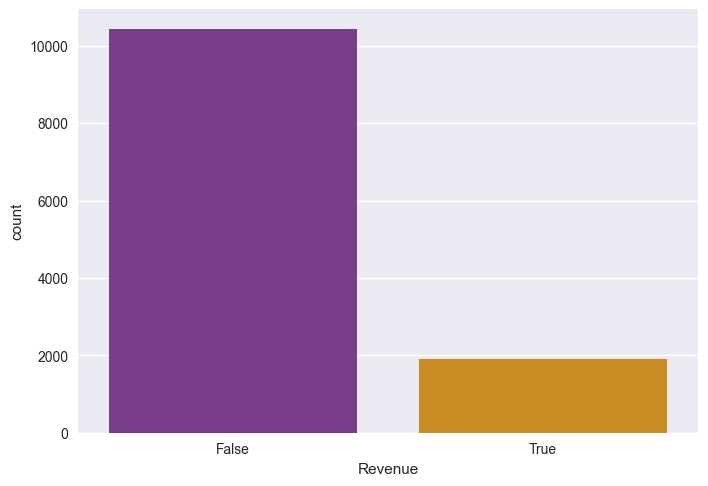

In [6]:
sns.countplot(x='Revenue', data=dummy_data, palette='CMRmap')
class_percent = dummy_data['Revenue'].value_counts(normalize=True) * 100
print('Sessions without purchase : {:.2f}%'.format(class_percent[0]))
print('Sessions with purchase: {:.2f}%'.format(class_percent[1]))

Из 12330 сессий покупкой товара завершаются лишь 15.47 %. Мы знаем, что такое соотношение классов заставляет нас смотреть на метрики для каждого из классов отдельно.

Условимся, что лучшей будет считаться та модель, у которой значение метрики  F1 для пользователей, совершивших покупку, будет наибольшим.

По традиции разделим набор данных на матрицу наблюдений X и вектор ответов y:

In [7]:
X, y = dummy_data.drop('Revenue', axis=1), dummy_data['Revenue']

Давайте заранее определимся, как мы будем производить контроль качества наших моделей:

Разделим выборку на тренировочную и тестовую.
Будем проводить кросс-валидацию на тренировочной выборке (то есть будем делить её на тренировочные и валидационные фолды и считать среднее значение метрики по фолдам).
Итого мы будем использовать три показателя:

значение метрики на тренировочных и валидационных фолдах кросс-валидации (по ним мы будем отслеживать переобучение модели и подбирать внешние параметры);
значение метрики на отложенной тестовой выборке (оно будет нашим контрольным показателем).
Другими словами, мы будем сочетать hold-оut- и k-fold-подходы к валидации.

In [9]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X,y, stratify=y, test_size=0.2, random_state=1)
print('Train shape:', X_train.shape)
print('Test shape:', X_test.shape)
print('Train:\n', y_train.value_counts(normalize=True), sep='')
print('Valid:\n', y_test.value_counts(normalize=True), sep='')

Train shape: (9864, 28)
Test shape: (2466, 28)
Train:
Revenue
False    0.845296
True     0.154704
Name: proportion, dtype: float64
Valid:
Revenue
False    0.845093
True     0.154907
Name: proportion, dtype: float64


In [24]:
rf_clf = ensemble.RandomForestClassifier(random_state=42)
rf_clf.fit(X_train, y_train)
skf = model_selection.StratifiedKFold(n_splits=5)
cv_metrics = model_selection.cross_validate(estimator=rf_clf, X=X_train, y=y_train, cv=skf, scoring='f1', return_train_score=True)
train_scores_mean = np.mean(cv_metrics['train_score'])
test_scores_mean = np.mean(cv_metrics ['test_score'])
display(train_scores_mean, test_scores_mean)

1.0

0.6349800955808512

In [25]:
def plot_learning_curve(model, X, y, cv, scoring="f1", ax=None, title=""):
    # Вычисляем координаты для построения кривой обучения
    train_sizes, train_scores, valid_scores = model_selection.learning_curve(
        estimator=model,  # модель
        X=X,  # матрица наблюдений X
        y=y,  # вектор ответов y
        cv=cv,  # кросс-валидатор
        scoring=scoring,  # метрика
    )
    # Вычисляем среднее значение по фолдам для каждого набора данных
    train_scores_mean = np.mean(train_scores, axis=1)
    valid_scores_mean = np.mean(valid_scores, axis=1)
    # Если координатной плоскости не было передано, создаём новую
    if ax is None:
        fig, ax = plt.subplots(figsize=(10, 4))  # фигура + координатная плоскость
    # Строим кривую обучения по метрикам на тренировочных фолдах
    ax.plot(train_sizes, train_scores_mean, label="Train")
    # Строим кривую обучения по метрикам на валидационных фолдах
    ax.plot(train_sizes, valid_scores_mean, label="Valid")
    # Даём название графику и подписи осям
    ax.set_title("Learning curve: {}".format(title))
    ax.set_xlabel("Train data size")
    ax.set_ylabel("Score")
    # Устанавливаем отметки по оси абсцисс
    ax.xaxis.set_ticks(train_sizes)
    # Устанавливаем диапазон оси ординат
    ax.set_ylim(0, 1)
    # Отображаем легенду
    ax.legend()

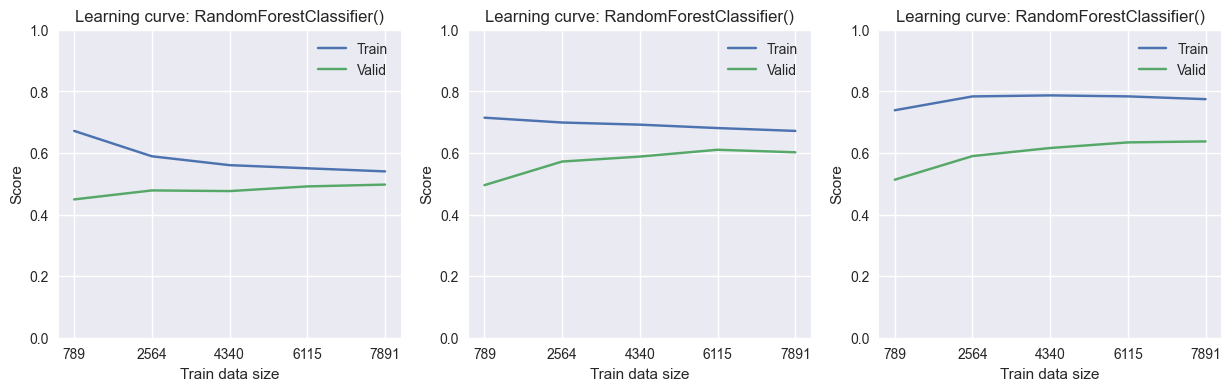

In [26]:
#Создаём список из моделей
models = [
    ensemble.RandomForestClassifier(n_estimators=200, min_samples_leaf=5, max_depth=5, random_state=42),
    ensemble.RandomForestClassifier(n_estimators=200, min_samples_leaf=5, max_depth=7, random_state=42),
    ensemble.RandomForestClassifier(n_estimators=200, min_samples_leaf=5, max_depth=12, random_state=42),
]
skf = model_selection.StratifiedKFold(n_splits=5)
#Визуализируем кривые обучения
fig, axes = plt.subplots(1, 3, figsize=(15, 4)) #фигура + 3 координатных плоскости
#Создаем цикл по списку моделей и индексам этого списка
for i, model in enumerate(models): #i-текущий индекс, model - текущая модель
    plot_learning_curve(
        model, X_train, y_train, 
        skf, 
        ax=axes[i], 
        title=model.__class__.__name__ + '()'
)

In [31]:
rf_clf_d = ensemble.RandomForestClassifier(n_estimators=200, min_samples_leaf=5, max_depth=7, random_state=42)
rf_clf_d.fit(X_train, y_train)
y_pred = rf_clf_d.predict(X_test)
print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       False       0.91      0.98      0.95      2084
        True       0.82      0.50      0.62       382

    accuracy                           0.91      2466
   macro avg       0.87      0.74      0.78      2466
weighted avg       0.90      0.91      0.90      2466



In [38]:
rf_clf_d = ensemble.RandomForestClassifier(n_estimators=200, min_samples_leaf=5, max_depth=7, random_state=42)
rf_clf_d.fit(X_train, y_train)
skf = model_selection.StratifiedKFold(n_splits=5)
y_cv_proba_pred = model_selection.cross_val_predict(rf_clf_d, X_train, y_train, cv = skf, method='predict_proba')
y_cv_proba_pred = y_cv_proba_pred [:, 1]
precision, recall, thresholds = metrics.precision_recall_curve(y_train, y_cv_proba_pred)
f1_scores = (2*precision*recall)/(precision+recall)
idx = np.argmax(f1_scores)
print('Best threshold = {:.2f}, F1-Score = {:.2f}'.format(thresholds[idx], f1_scores[idx]))


Best threshold = 0.33, F1-Score = 0.68


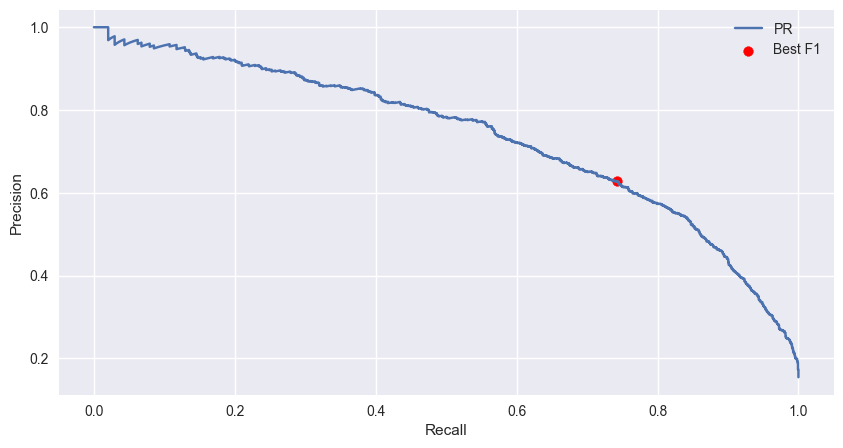

In [37]:
fig, ax = plt.subplots(figsize = (10,5))
ax.plot(recall, precision, label = 'PR')
ax.scatter(recall[idx], precision[idx], marker = 'o', color = 'red', label = 'Best F1')
ax.set_xlabel('Recall')
ax.set_ylabel('Precision')
ax.legend()

In [39]:
thresholds_opt = 0.33
y_test_pred_proba = model.predict_proba(X_test)[:,1]
y_test_pred = (y_test_pred_proba>thresholds_opt).astype('int')
print(metrics.classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

       False       0.95      0.92      0.94      2084
        True       0.64      0.75      0.69       382

    accuracy                           0.90      2466
   macro avg       0.80      0.84      0.81      2466
weighted avg       0.90      0.90      0.90      2466

